In [1]:
import os
import re
import nltk
import random
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import ngrams
from nltk import pos_tag
from nltk import FreqDist
from nltk.chunk import RegexpParser
from nltk.stem import *
import string
import math
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
# path for input text files
data_path = "data\\data\\"

# separate into positive and negative
neg_list = os.listdir(data_path + "neg")
pos_list = os.listdir(data_path + "pos")

all_reviews = neg_list + pos_list


def get_target_values(data_set):
    output_id = []
    output_rating = []
    for doc_id in data_set:
        rating = doc_id.split('_')[1].split('.')[0]
        output_id.append(doc_id)
        output_rating.append(rating)
    return output_id, output_rating

all_doc_id, all_doc_rating = get_target_values(all_reviews)  # Retrieve all document ID's and associated ratings in 2 lists

train_id, X_temp, train_ratings, y_temp = train_test_split(all_doc_id, all_doc_rating, test_size=0.2, random_state=42, stratify=all_doc_rating) # Split to training and temp

dev_id, test_id, dev_ratings, test_ratings = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # Split temp into dev and test

def populate_set(data_set, data_set_rating, data_path):
    output_set = {}
    for rating_id, id in enumerate(data_set):
        if int(data_set_rating[rating_id]) < 5:
            with open(data_path + "neg\\" + id, "r", encoding="utf8") as f:
                output_set[id] = f.read()
        else:
            with open(data_path + "pos\\" + id, "r", encoding="utf8") as f:
                output_set[id] = f.read()
    return output_set

data_path = "data\\data\\"
training_set = {}  # 80% 3200
dev_set = {}  # 10% 400
test_set = {}  # 10% 400

# Populate data sets
training_set = populate_set(train_id, train_ratings, data_path)
dev_set = populate_set(dev_id, dev_ratings, data_path)
test_set = populate_set(test_id, test_ratings, data_path)
print(len(training_set))
print(len(dev_set))
print(len(test_set))
train_rating_dict = {}
dev_rating_dict = {}
test_rating_dict = {}
for rating in train_ratings:
    if rating in train_rating_dict.keys():
        train_rating_dict[rating] += 1
    else:
        train_rating_dict[rating] = 1
for rating in dev_ratings:
    if rating in dev_rating_dict.keys():
        dev_rating_dict[rating] += 1
    else:
        dev_rating_dict[rating] = 1
for rating in test_ratings:
    if rating in test_rating_dict.keys():
        test_rating_dict[rating] += 1
    else:
        test_rating_dict[rating] = 1
print(train_rating_dict)
print(dev_rating_dict)
print(test_rating_dict)


3200
400
400
{'3': 400, '10': 400, '9': 400, '1': 400, '2': 400, '7': 400, '4': 400, '8': 400}
{'4': 50, '7': 50, '3': 50, '10': 50, '9': 50, '2': 50, '8': 50, '1': 50}
{'3': 50, '9': 50, '4': 50, '2': 50, '8': 50, '1': 50, '10': 50, '7': 50}


In [3]:
def nltk_tokenize(data_set, stemming, lemmatization, ngram_cond):
    output = {}
    stopword_list = set(stopwords.words('english'))
    st = PorterStemmer()
    lem = WordNetLemmatizer()
    grammar_NP = "NP: {<DT>?<JJ>*<NN>+}"
    chunker = RegexpParser(grammar_NP)

    for doc_id, text in data_set.items():

        tokens = [word.lower() for word in word_tokenize(text)]  # Tokenize text and set to lowercase


        pos_tags = pos_tag(tokens)  # Generate POS tags
        
        tree = chunker.parse(pos_tags)  # Use chunking to gather noun phrases
        NP = []  # Noun Phrases
        for subtree in tree.subtrees():
            if subtree.label() == "NP":
                NP.append(" ".join(word for word, tag in subtree.leaves()))

        if stemming == True:
            tokens_edited = [st.stem(word) for word in tokens]
            NP_edited = [st.stem(phrase) for phrase in NP]
        elif lemmatization == True:
            tokens_edited = [lem.lemmatize(word) for word in tokens]
            NP_edited = [lem.lemmatize(phrase) for phrase in NP]
        else:
            tokens_edited = tokens
            NP_edited = NP

        ngram = []
        
        if ngram_cond == 2:
            ngram = ['_'.join(gram) for gram in ngrams(tokens, 2)]  # generate bigrams using ngrams function
        if ngram_cond == 3:
            ngram = ['_'.join(gram) for gram in ngrams(tokens, 3)]  # generate trigrams using ngrams function

        # NEED TO EDIT THIS TO MAKE SURE IT REMOVES STOPWORDS FROM BIGRAMS AND TRIGRAMS
        tokens_edited = [word for word in tokens_edited if word not in stopword_list and word not in string.punctuation and word not in ["br", '``', "n't", "''", "...", "'s", "'re"]]  # Remove stopword, punctuation and misc.
        NP_edited = [word for word in NP_edited if word not in stopword_list and word not in string.punctuation and word not in ["br", '``', "n't", "''", "...", "'s", "'re"]]

        if ngram_cond == 2 or ngram_cond == 3:
            combined_tokens = list(set(tokens_edited + NP_edited + ngram))  # Combine all to get an output
        else:
            combined_tokens = list(set(tokens_edited + NP_edited))
        
        output[doc_id] = combined_tokens
    return output

In [4]:
def collect_vocabulary(training_set):
    all_terms = []
    for key, text in training_set.items():
        for word in text:
            all_terms.append(word)
    return list(set(all_terms))

In [5]:
def collect_doc_term_count(all_terms, doc_term_freqs):  # Returns a dictionary of terms with counts of how many documents the term appears in
    count_term_appears_in_unique_doc = {}
    for doc_id in doc_term_freqs.keys():
        for term in all_terms:
            if term in doc_term_freqs[doc_id].keys():
                if term in count_term_appears_in_unique_doc.keys():
                    count_term_appears_in_unique_doc[term] = count_term_appears_in_unique_doc[term] + 1
                else:
                    count_term_appears_in_unique_doc[term] = 1
    return count_term_appears_in_unique_doc

In [6]:
def count_terms(training_set):
    doc_term_freqs = {}
    for doc_id in training_set.keys():
        term_freqs = {}
        for word in training_set[doc_id]:
            if word in term_freqs:
                term_freqs[word] += 1
            else:
                term_freqs[word] = 1
        # Sublinear TF scaling as a secondary form of normalisation
        for word in term_freqs.keys():
            term_freqs[word] = 1 + math.log(term_freqs[word], 10)
        # Normalise by document length
        doc_length = len(training_set[doc_id])
        for word in term_freqs.keys():
            term_freqs[word] /= doc_length
        # Add sublinear scaled normalised TF to output dictionary
        doc_term_freqs[doc_id] = term_freqs
    return doc_term_freqs

In [7]:
def calculate_idfs(data_set, all_terms, doc_term_count):
    term_idfs = {}
    for term in all_terms:
        term_doc_count = doc_term_count.get(term)  # no. of documents containing the term
        if term_doc_count != None:
            term_idfs[term] = math.log(1 + (len(data_set)/float(1 + term_doc_count)), 10)
    return term_idfs

In [8]:
def get_tf_idf_dict(data_set, doc_term_freqs, term_idfs):
    all_doc_tf_idf = {}
    for doc_id, tokens in data_set.items():
        doc_tf_idf = {}
        for token, idf in term_idfs.items():
            if token in tokens:
                doc_tf_idf[token] = doc_term_freqs[doc_id][token] * idf
            else:
                doc_tf_idf[token] = 0.0
        all_doc_tf_idf[doc_id] = doc_tf_idf
    return all_doc_tf_idf

In [9]:
def vectorize_tfidf(norm_all_doc_tfidf):
    output = []
    for doc_id in norm_all_doc_tfidf.keys():
        document_vector = []
        for term in norm_all_doc_tfidf[doc_id].keys():
            document_vector.append(float(norm_all_doc_tfidf[doc_id][term]))
        output.append(document_vector)
    return np.array(output)

In [10]:
def get_target_values(data_set):
    output = []
    for doc_id in data_set.keys():
        rating = doc_id.split('_')[1].split('.')[0]
        if int(rating) >= 7:
            output.append("P")
        else:
            output.append("N")
    return output

In [11]:
def normalise_tfidf(all_doc_tfidf):
    for doc_id in all_doc_tfidf.keys():
        max_idf = 0.0
        for term in all_doc_tfidf[doc_id].keys():
            idf_value = all_doc_tfidf[doc_id][term]
            if float(idf_value) > max_idf:
                max_idf = idf_value
        for term in all_doc_tfidf[doc_id].keys():
            all_doc_tfidf[doc_id][term] = all_doc_tfidf[doc_id][term] / max_idf  # Normalise TFIDF values so they are between 0 and 1
    return all_doc_tfidf

In [12]:
def l2_norm(data_set, doc_term_freq, doc_term_count):
    normalised_documents = []
    for doc_id in data_set.keys():
        for term in doc_term_count.keys():
            document = []
            if term in doc_term_freq[doc_id].keys():
                document.append(doc_term_freq[doc_id][term])
            else:
                document.append(0)
        document = np.linalg.norm(document, keepdims=True)
        normalised_documents.append(document)
    return normalised_documents

In [13]:
training_set = nltk_tokenize(training_set, stemming=False, lemmatization=False, ngram_cond = 2)  # Tokenize, lemmatize and stem documents => Dict[Doc_ID] : Tokens
dev_set = nltk_tokenize(dev_set, stemming=False, lemmatization=False, ngram_cond=2)
#test_set = nltk_tokenize(test_set, stemming=False, lemmatization=False)

all_terms = collect_vocabulary(training_set)  # Retrieve list of all terms => all_terms (unique)

doc_term_freq = count_terms(training_set)  # Retrieve term frequency values for each term in each document => Dict[Doc_ID] : Dict[Token] : TF
dev_dtf = count_terms(dev_set)  # Retrieve TF for each term in each document for dev set
#test_dtf = count_terms(test_set)

# Need to get IDF values for each word in corpus = total no docs in corpus/no docs containing word

doc_term_count = collect_doc_term_count(all_terms, doc_term_freq)  # Returns a dictionary of each term in the corpus and how many documents it appears in => Dict[term] : CorpusFreq

doc_term_count = {word: count for word, count in doc_term_count.items() if 80 <= count <= 1800}


#term_l2_norm = l2_norm(training_set, doc_term_freq, doc_term_count)

#print(term_l2_norm[0])

term_idfs = calculate_idfs(training_set, all_terms, doc_term_count)  # Returns a dictionary of each term in the corpus => Dict[term] : IDF

# Need a function that takes in a data set (training/dev/test) and returns a dictionary of tfidf values => Dict[doc_id] : Dict[Term] : TFIDF

all_doc_tfidf = get_tf_idf_dict(training_set, doc_term_freq, term_idfs)  # Returns a dictionary of tfidf values for all documents in data set => Dict[doc_id] : Dict[Term] : TFIDF
dev_tfidf = get_tf_idf_dict(dev_set, dev_dtf, term_idfs)
#test_tfidf = get_tf_idf_dict(test_set, test_dtf, term_idfs)
# Need a function to normalise each documents tfidf scores so that it is between 0 and 1 to account for document length

norm_all_doc_tfidf = normalise_tfidf(all_doc_tfidf)  # Returns normalised tfidf values for all training documents by dividing all tfidf scores in each document by the maximum tfidf value of that document
                                                     # Dict[doc_id] : Dict[Term] : TFIDF (normalised)

norm_dev_tfidf = normalise_tfidf(dev_tfidf)
#norm_test_tfidf = normalise_tfidf(test_tfidf)

# Need a function to vectorize all_doc_tfidf so that it can be passed into NB classifier

train_vec_tfidf = vectorize_tfidf(norm_all_doc_tfidf)
dev_vec_tfidf = vectorize_tfidf(norm_dev_tfidf)
#test_vec_tfidf = vectorize_tfidf(norm_test_tfidf)

# Need a function to get the target values in a vector

training_target_values = get_target_values(training_set)  # Training vector
dev_target_values = get_target_values(dev_set)  # Development vector
#test_target_values = get_target_values(test_set)  # Test vector





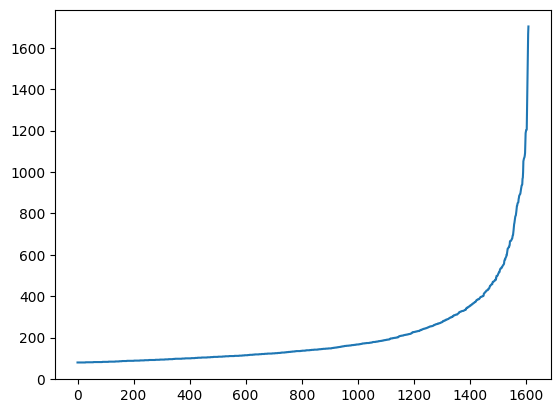

In [14]:
#  Visualisation of training term frequency in unique documents indicating significance of each term: Common terms and very low frequency terms are are less significant.
import matplotlib.pyplot as plt
term_freqs = [count for word, count in sorted(doc_term_count.items(), key=lambda item: item[1])]
x_axis = np.arange(0, len(term_freqs), 1)
plt.plot(x_axis, term_freqs)
plt.show()
for index, freq in enumerate(term_freqs):
    if freq == 16:
        print(index)
        break

In [15]:
X = train_vec_tfidf
Y = dev_vec_tfidf

print(X.shape)
print(Y.shape)
for i in np.arange(0.01, 1.01, 0.01):
    clf = MultinomialNB(alpha=i)
    clf.fit(X, training_target_values)
    print(i, clf.score(Y, dev_target_values))

(3200, 1610)
(400, 1610)
0.01 0.8175
0.02 0.8175
0.03 0.8175
0.04 0.8175
0.05 0.8175
0.060000000000000005 0.8175
0.06999999999999999 0.8175
0.08 0.8175
0.09 0.8175
0.09999999999999999 0.8175
0.11 0.8175
0.12 0.8175
0.13 0.8175
0.14 0.8175
0.15000000000000002 0.8175
0.16 0.8175
0.17 0.8175
0.18000000000000002 0.8175
0.19 0.8175
0.2 0.8175
0.21000000000000002 0.8175
0.22 0.8175
0.23 0.8175
0.24000000000000002 0.8175
0.25 0.8175
0.26 0.8175
0.27 0.8175
0.28 0.8175
0.29000000000000004 0.8175
0.3 0.8175
0.31 0.8175
0.32 0.8175
0.33 0.8175
0.34 0.8175
0.35000000000000003 0.8175
0.36000000000000004 0.8175
0.37 0.8175
0.38 0.8175
0.39 0.8175
0.4 0.8175
0.41000000000000003 0.8175
0.42000000000000004 0.8175
0.43 0.8175
0.44 0.8175
0.45 0.8175
0.46 0.8175
0.47000000000000003 0.8175
0.48000000000000004 0.8175
0.49 0.8175
0.5 0.8175
0.51 0.8175
0.52 0.8175
0.53 0.8175
0.54 0.8175
0.55 0.8175
0.56 0.8175
0.5700000000000001 0.8175
0.5800000000000001 0.8175
0.59 0.815
0.6 0.815
0.61 0.815
0.62 0.815
0

In [16]:
## Insert code here for manual NB classifier
class NBClassifier:
    def __init__(self, alpha, feature_count):
        self.alpha = alpha
        self.log_class_conditional_likelihoods = 0
        self.log_class_priors = 0
        self.feature_count = feature_count


    def estimate_log_class_priors(self):
        """
        Given a data set with binary response variable (0s and 1s) in the
        left-most column, calculate the logarithm of the empirical class priors,
        that is, the logarithm of the proportions of 0s and 1s:
            log(p(C=0)) and log(p(C=1))

        :param data: a two-dimensional numpy-array with shape = [n_samples, 1 + n_features]
                    the first column contains the binary response (coded as 0s and 1s).

        :return log_class_priors: a numpy array of length two

        OLD CODE REMOVE LATER IF NOT NEEDED
        probN = 0
        probP = 0
        for row in data:
            if row[0] == 1:
                probN = probN + 1
            else:
                probP = probP + 1
        probN = np.log(probN/len(data))
        probP = np.log(probP/len(data))
        log_class_priors = np.array((probP, probN))
        """
        #  Log class priors should be equal as training data is equally distributed between positive and negative reviews
        log_class_priors = np.array((np.log(0.5), np.log(0.5)))
        return log_class_priors
    
    def get_class_values(self, tfidf_vec, target_values): #tfidf_vec = dev_vec_tfidf example
        total_tfidfs_pos = 0
        total_tfidfs_neg = 0
        tfidfs_pos = np.zeros_like(tfidf_vec[0])
        tfidfs_neg = np.zeros_like(tfidf_vec[0])
        for i in range(len(tfidf_vec)):
            sentiment = target_values[i]
            if sentiment == "P":
                total_tfidfs_pos += np.sum(tfidf_vec[i])
                tfidfs_pos += tfidf_vec[i]
            else:
                total_tfidfs_neg += np.sum(tfidf_vec[i])
                tfidfs_neg += tfidf_vec[i]
        return total_tfidfs_pos, total_tfidfs_neg, tfidfs_pos, tfidfs_neg
        

        
        
    def estimate_log_class_conditional_likelihoods(self, total_tfidfs_pos, total_tfidfs_neg, tfidfs_pos, tfidfs_neg):
        """
        Given a data set with binary response variable (0s and 1s) in the
        left-most column and binary features (words), calculate the empirical
        class-conditional likelihoods, that is,
        log(P(w_i | c)) for all features w_i and both classes (c in {0, 1}).

        Assume a multinomial feature distribution and use Laplace smoothing
        if alpha > 0.

        :param data: a two-dimensional numpy-array with shape = [n_samples, 1 + n_features]

        :return theta:
            a numpy array of shape = [2, n_features]. theta[j, i] corresponds to the
            logarithm of the probability of feature i appearing in a sample belonging 
            to class j.
        """
        alpha = self.alpha
        PPOS = np.log((tfidfs_pos + alpha)/(total_tfidfs_pos + alpha * len(tfidfs_pos)))
        PNEG = np.log((tfidfs_neg + alpha)/(total_tfidfs_neg + alpha * len(tfidfs_neg)))
        theta = np.array((PPOS, PNEG))

        return theta

    def predict(self, new_data):
        class_predictions = np.empty(len(new_data), dtype=str)
        for document, terms in enumerate(new_data):
            PosRating = self.log_class_priors[0] + np.sum(terms * self.log_class_conditional_likelihoods[0])
            NegRating = self. log_class_priors[1] + np.sum(terms * self.log_class_conditional_likelihoods[1])
            if PosRating > NegRating:
                class_predictions[document] = "P"
            else:
                class_predictions[document] = "N"
        return class_predictions
    
    def train(self, tfidf_vec, target_values):
        self.log_class_priors = self.estimate_log_class_priors()
        total_tfidfs_pos, total_tfidfs_neg, tfidfs_pos, tfidfs_neg = self.get_class_values(tfidf_vec, target_values)
        self.log_class_conditional_likelihoods = self.estimate_log_class_conditional_likelihoods(total_tfidfs_pos, total_tfidfs_neg, tfidfs_pos, tfidfs_neg)

def create_classifier(features, tfidf_vec, target_values):
    classifier = NBClassifier(alpha=0.8, feature_count=features)
    classifier.train(tfidf_vec, target_values)
    return classifier

feature_count = X.shape[1]
classifier = create_classifier(feature_count, train_vec_tfidf, training_target_values)
predictions = classifier.predict(dev_vec_tfidf)
correct_count = 0
for index, pred in enumerate(predictions):
    if pred == dev_target_values[index]:
        correct_count += 1
print(correct_count/400)
#52

0.815
